# OpenPIV tutorial 1


In this tutorial we read the pair of images using `imread`, compare them visually 
and process using OpenPIV. Here the import is using directly the basic functions and methods

In [1]:
from openpiv import tools, pyprocess, validation, filters, scaling 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import cv2 # Added for image equalozation
from math import *
import imageio

folder = '/home/edo20/PIV'

In [2]:
# Experimental data

# Camera
resolution = (992,1004) #pixel
physical_window = (45,45) # m
pixel_depth = 8 # bit
dynamic_range = 2**pixel_depth # levels
scaling_factor = 1/(np.mean(physical_window)/np.mean(resolution)) # m/pixel
image_number = '052'

In [3]:
frame_a  = tools.imread( folder + '/Images/A' + image_number + 'a.tif' )
frame_b  = tools.imread( folder + '/Images/A' + image_number + 'b.tif' )

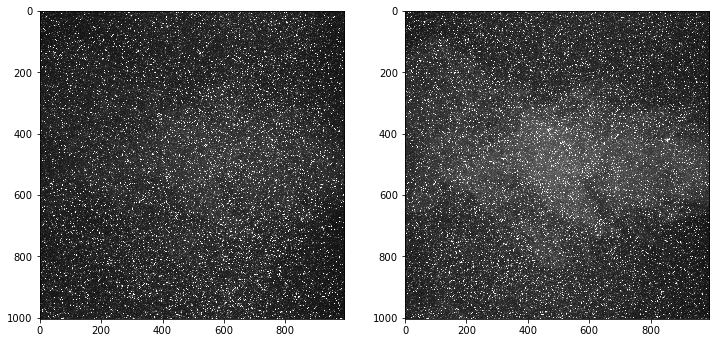

In [4]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

In [5]:
# Image equalization
def image_equalization(frame,dynamic_range,plot=0):
    frame = np.array(frame)
    # Histogram and cdf of the original image
    hist,bins = np.histogram(frame.flatten(),dynamic_range,[0,dynamic_range])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    
    #Image equalization
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    frameEQ = cdf[frame]    
    
    # Histogram and cdf of the equalized image
    frameEQ = np.array(frameEQ)
    histEQ,binsEQ = np.histogram(frameEQ.flatten(),dynamic_range,[0,dynamic_range])
    cdfEQ = histEQ.cumsum()
    cdf_normalizedEQ = cdfEQ * histEQ.max()/ cdfEQ.max()
    
    # Plot
    if plot:
        # Oriinal image
        ax1 = plt.subplot(1,2,1)
        ax1.plot(cdf_normalized, color = 'b')
        ax1.hist(frame.flatten(),dynamic_range,[0,dynamic_range], color = 'r')
        ax1.set_xlim([0,dynamic_range])
        ax1.legend(('cdf','histogram'), loc = 'upper left')
        ax1.set_title('Original image')
        # Equalized image
        ax2 = plt.subplot(1,2,2)
        ax2.plot(cdf_normalizedEQ, color = 'b')
        ax2.hist(frameEQ.flatten(),dynamic_range,[0,dynamic_range], color = 'r')
        ax2.set_xlim([0,dynamic_range])
        ax2.legend(('cdf','histogram'), loc = 'upper left')
        ax2.set_title('Equalized image')
        plt.show()
        
    return frameEQ

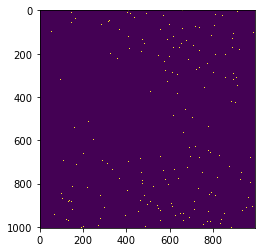

In [6]:
# Put a random noise where the image is saturated
index = (frame_a==255) * (frame_b==255)
plt.imshow(index)

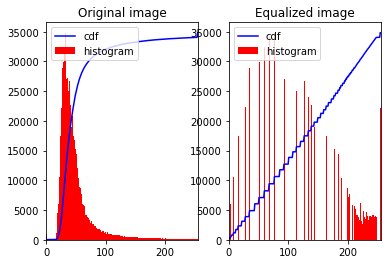

In [7]:
frame_a = image_equalization(frame_a,dynamic_range,plot=1)

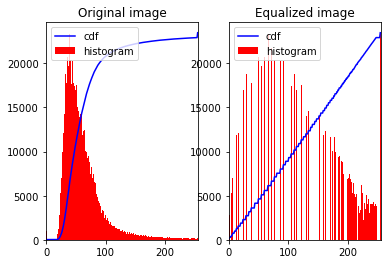

In [8]:
frame_b = image_equalization(frame_b,dynamic_range,plot=1)

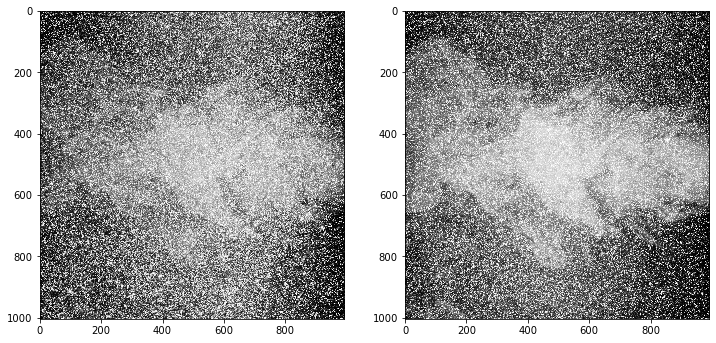

In [9]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

In [10]:
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 40  # pixels, search in image B
overlap = 16 # pixels, 50% overlap
dt = 1/15 # sec, time interval between pulses


u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

In [11]:
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

(array([ 72.,   0.,   0.,   0., 257., 535., 448., 243.,  77.,   8.]),
 array([0.        , 0.24657569, 0.49315138, 0.73972707, 0.98630276,
        1.23287845, 1.47945414, 1.72602983, 1.97260552, 2.21918121,
        2.4657569 ]),
 <a list of 10 Patch objects>)

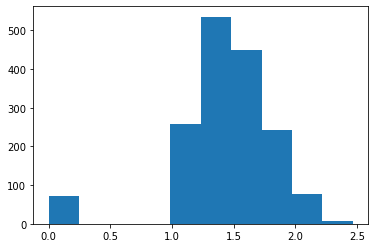

In [12]:
u1, v1, mask = validation.sig2noise_val( u0, v0, 
                                        sig2noise, 
                                        threshold = 1.05 )
plt.hist(sig2noise.flatten())
# if you need more detailed look, first create a histogram of sig2noise
# plt.hist(sig2noise.flatten())
# to see where is a reasonable limit

In [13]:
# filter out outliers that are very different from the
# neighbours

u2, v2 = filters.replace_outliers( u1, v1, 
                                  method='localmean', 
                                  max_iter=3, 
                                  kernel_size=3)


In [14]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(x, y, u2, v2, 
                               scaling_factor = scaling_factor )


In [15]:
#save in the simple ASCII table format
tools.save(x, y, u3, v3, sig2noise, mask, folder + '/Vector_field/exp1_' + image_number + '.txt' )

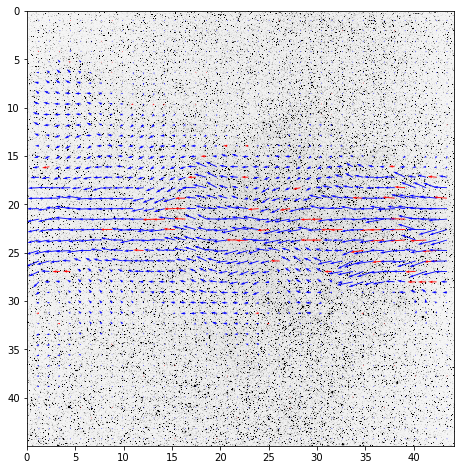

In [16]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field( folder + '/Vector_field/exp1_' + image_number + '.txt', 
                           ax=ax, scaling_factor=scaling_factor, 
                           scale= 100, # scale defines here the arrow length
                           width= 0.002, # width is the thickness of the arrow
                           on_img= True, # overlay on the image
                           image_name= folder + '/Images/A' + image_number + 'a.tif');